In [8]:
import os
from pathlib import Path,PureWindowsPath
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import flopy

%matplotlib inline


def save_obj(dirname,obj, name ):
    import pickle
    with open(dirname.joinpath(name + '.pkl').as_posix(), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(dirname,name):
    import pickle
    with open(dirname.joinpath(name + '.pkl').as_posix(), 'rb') as f:
        return pickle.load(f)

In [2]:
dirname_mpwsp = str(PureWindowsPath('E:\Python\MPWSP_Models\Calibrated2\Calibrated'))
mload = flopy.modflow.Modflow.load('nm_cali.nam', model_ws = str(dirname_mpwsp),check=False)

C:\Program Files\Anaconda3\lib\site-packages\flopy\plot\map.py:387: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plotarray[idx] = 1


WEL
GHB


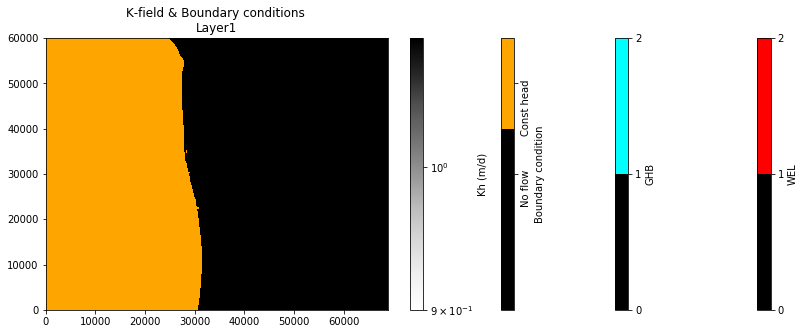

WEL
GHB


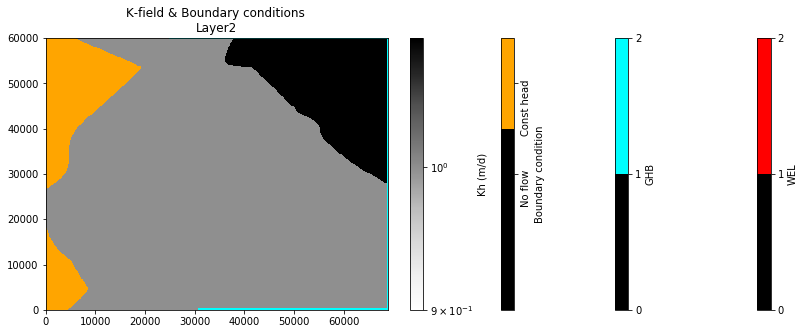

WEL
GHB


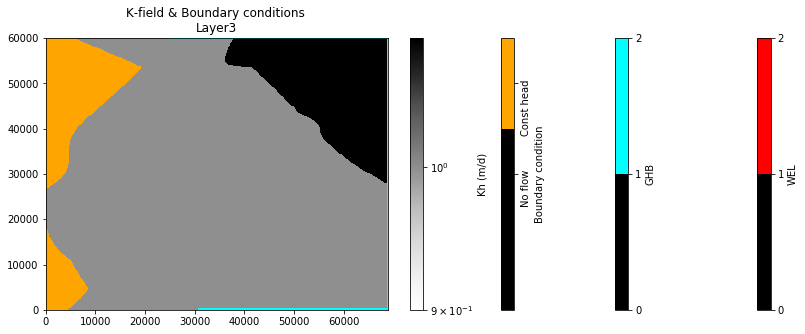

WEL
GHB


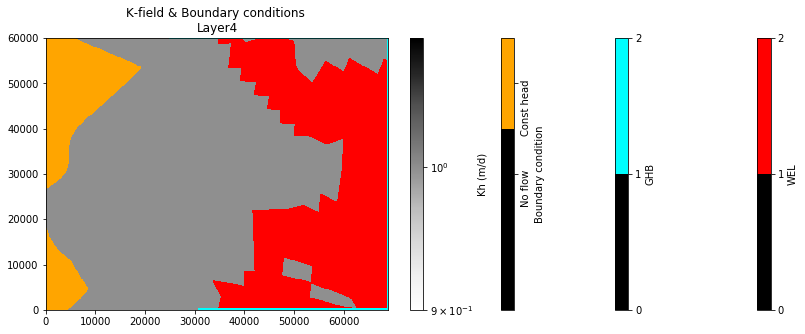

WEL
GHB


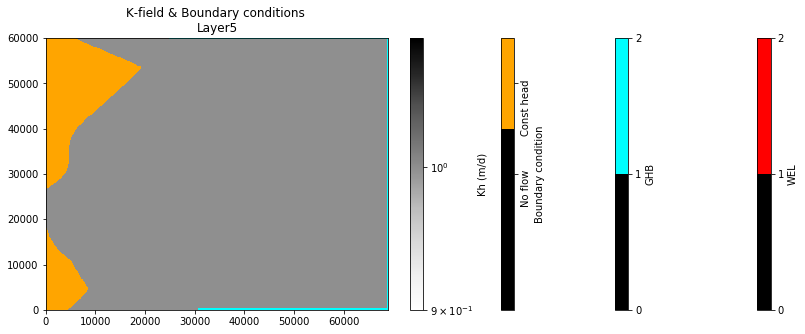

WEL
GHB


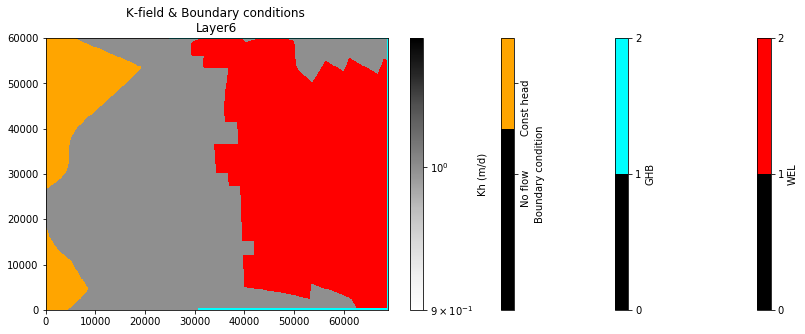

WEL
GHB


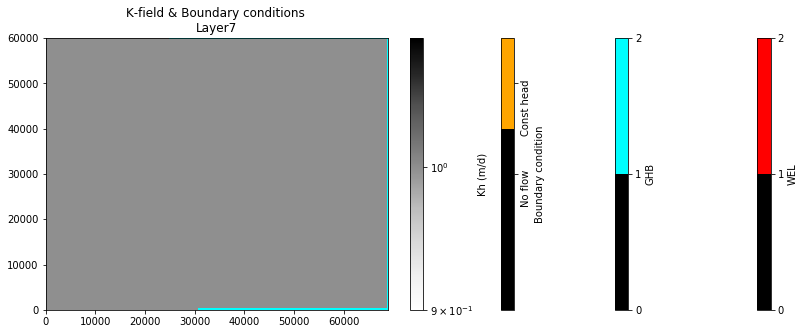

WEL
GHB


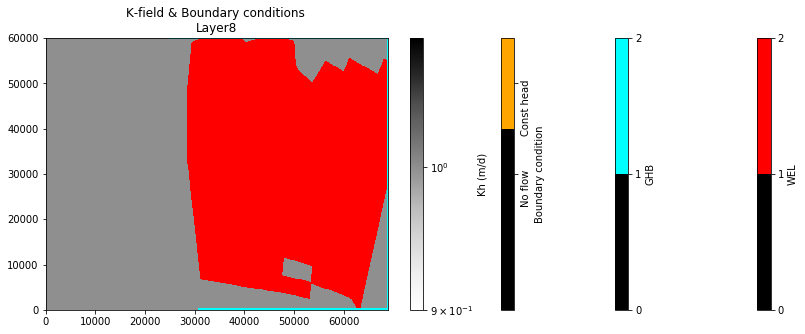

In [69]:
rowslice=1
gridon=0

hk = np.ones((mload.nlay,mload.nrow,mload.ncol))
#mm = flopy.plot.ModelCrossSection(ax=ax, model=mload, line={'row':rowslice})
for lay in range(mload.nlay):
    f = plt.figure(figsize=(15, 5))
    plt.clf()
    ax = f.add_subplot(1, 1, 1)
    mm= flopy.plot.ModelMap(ax=ax, model=mload,layer=lay)
    hkpatchcollection = mm.plot_array(hk, norm=matplotlib.colors.LogNorm(),vmin=np.min(hk), vmax=np.max(hk),cmap='Greys')
    patchcollection = mm.plot_ibound(color_ch='orange');
    itype = flopy.mt3d.Mt3dSsm.itype_dict()
    cbs= []
    for ftype in list(itype.keys()):
        try:
            patch = mm.plot_bc(ftype=ftype)
            print(ftype)
            #patch.set_ticks((1.5,2.5))
            #patch.set_label(str(ftype), rotation=90)
            cbs.append(plt.colorbar(patch,label=str(ftype)))
        except:
            pass
    if patchcollection:
        cb = plt.colorbar(patchcollection);
        cb.set_label('Boundary condition',rotation=90)
        cb.set_ticks((1.5,2.5))
        cb.ax.set_yticklabels(('No flow','Const head'),rotation=90)
    cb2 = plt.colorbar(hkpatchcollection,ax=ax);
    cb2.set_label('Kh (m/d)', rotation=90)
    plt.title('K-field & Boundary conditions \nLayer{}'.format(lay+1));
    plt.show()


In [193]:

ghb_dict = {}
kper = 1
for i in range(mload.nrow-1):
    ghb_row = np.where(mload.ghb.stress_period_data.data[kper]['i']==i)[0]
    ghb_col = np.where(mload.ghb.stress_period_data.data[kper]['j']==mload.ncol-1)[0]
    ind  = list(set(ghb_row) & set(ghb_col))
    if len(ind)>0:
        rec = np.recarray(shape=len(ind),names=('k','i','j','ind','bhead','cond'),
                      formats=['<i4','<i4','<i4','<i4','<f4','<f4'])
        rec['k'] = mload.ghb.stress_period_data.data[kper]['k'][ind]
        rec['i'] = mload.ghb.stress_period_data.data[kper]['i'][ind]
        rec['j'] = mload.ghb.stress_period_data.data[kper]['j'][ind]
        rec['ind'] = ind
        rec['bhead'] = mload.ghb.stress_period_data.data[kper]['bhead'][ind]
        rec['cond'] = mload.ghb.stress_period_data.data[kper]['cond'][ind]
        ghb_dict[i] = rec

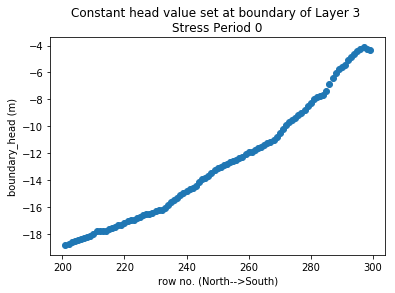

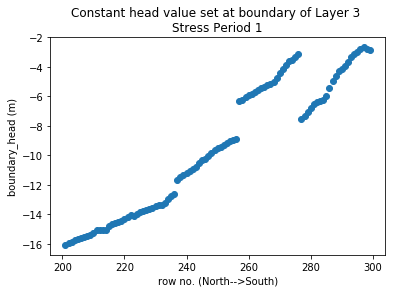

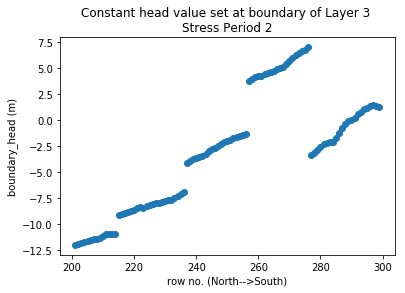

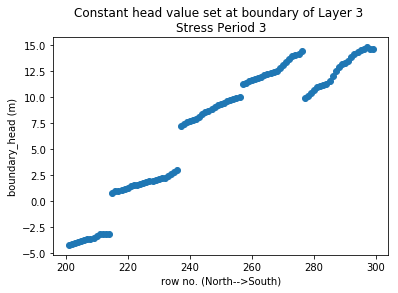

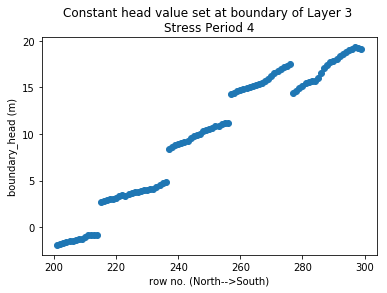

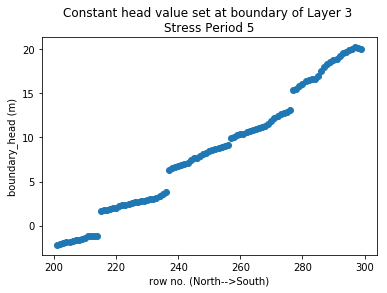

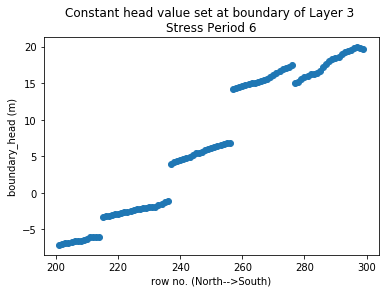

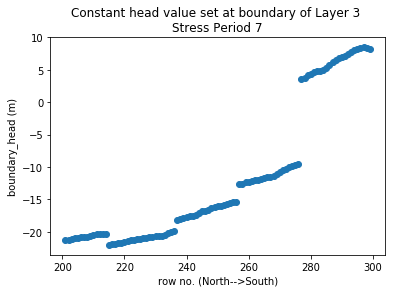

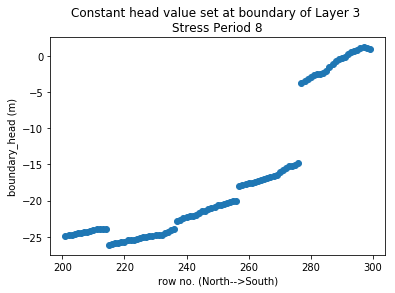

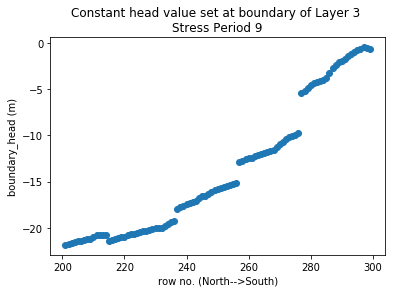

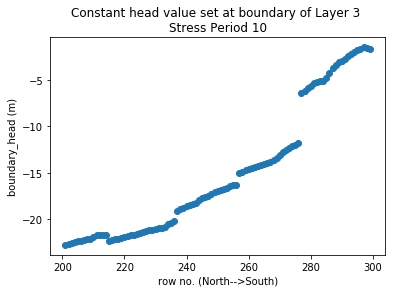

In [362]:
avg_bhead_nmarina = []
min_bhead_nmarina = []
max_bhead_nmarina = []
lay = 3
for kper in range(mload.dis.nper):
    indlay = np.where(mload.ghb.stress_period_data.data[kper]['k']==lay)[0]
    indcol = np.where(mload.ghb.stress_period_data.data[kper]['j']==mload.ncol-1)[0]
    ind = list(set(indlay) & set(indcol))

    row = mload.ghb.stress_period_data.data[kper]['i'][ind]
    col = mload.ghb.stress_period_data.data[kper]['j'][ind]
    bhead = mload.ghb.stress_period_data.data[kper]['bhead'][ind]
    '''
    print(row)
    print(col)
    print(bhead)
    '''
    ghb_arr = np.zeros((mload.nrow,mload.ncol),dtype=float)
    ind_tup = (row,col)
    ghb_arr[ind_tup] = bhead
    ghb_arr_ma = np.ma.masked_array(ghb_arr,mask=ghb_arr==0.0)
    #plt.imshow(ghb_arr_ma)
    avg_bhead_nmarina.append(np.mean(bhead[np.where(row>200)]))
    min_bhead_nmarina.append(min(bhead[np.where(row>200)]))
    max_bhead_nmarina.append(min(bhead[np.where(row>200)]))
    if not kper in np.arange(0,11):
        continue
    plt.figure()
    plt.scatter(row[np.where(row>200)],bhead[np.where(row>200)])
    plt.xlabel('row no. (North-->South)')
    plt.ylabel('boundary_head (m)')
    plt.title('Constant head value set at boundary of Layer {} \nStress Period {}'.format(lay,kper))
    

Text(0.5,1,'Average Boundary Head in 180-Foot Aquifer \nin N Marina Area for each month')

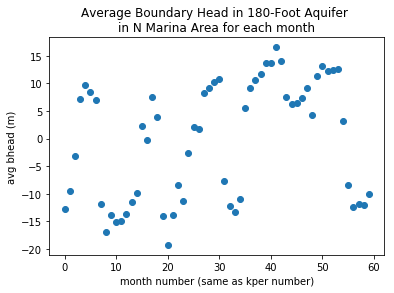

In [339]:
plt.scatter(np.arange(len(avg_bhead_nmarina))[:12*5],avg_bhead_nmarina[:12*5])
plt.xlabel('month number (same as kper number)')
plt.ylabel('avg bhead (m)')
plt.title('Average Boundary Head in 180-Foot Aquifer \nin N Marina Area for each month')

### Range of groundwater recharge values
As a range of values of recharge in the winter/wet season for the Monte Carlo we will take the [mean,max] of the average boundary head in the NMGWM2016 across rows 200-300, which correspond roughly to the area up-strike from North Marina. As the summer/dry season, we will take hte [min,mean] of the average boundary head.

In [461]:
rng_summer = (min(avg_bhead_nmarina),np.mean(avg_bhead_nmarina))
rng_winter = (np.mean(avg_bhead_nmarina), max(avg_bhead_nmarina))
print('Summer:',rng_summer,'m')
print('Winter:',rng_winter,'m')
exp_dirname = PureWindowsPath('E:\Projects\DelawareSGD')
fname = 'ghb_rng_model_edge'
save_obj(exp_dirname,(rng_summer,rng_winter),fname)

Summer: (-35.28707, -7.4100976) m
Winter: (-7.4100976, 16.54515) m


### Range of surface precipitation recharge values 



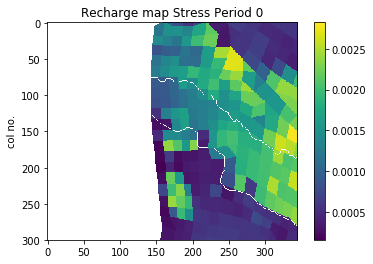

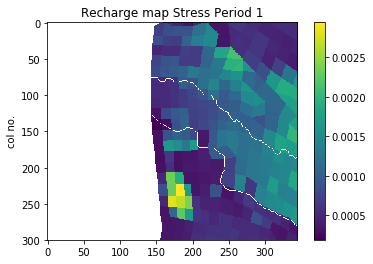

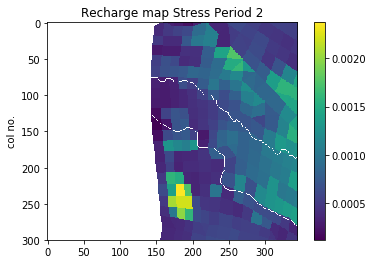

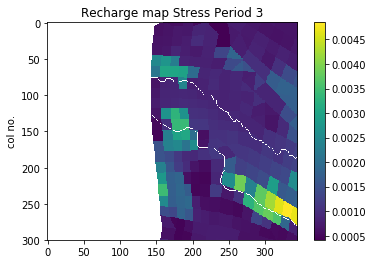

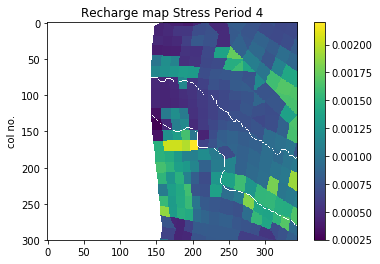

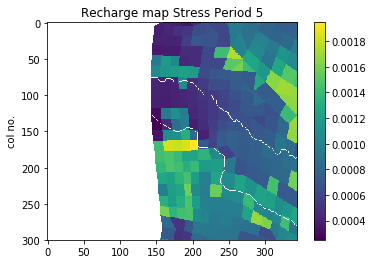

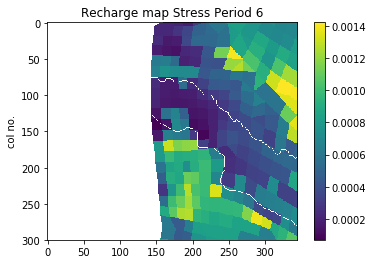

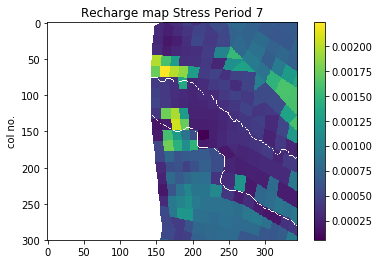

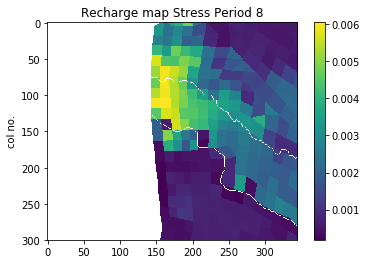

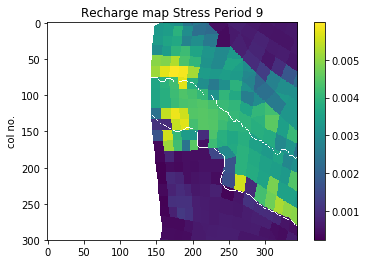

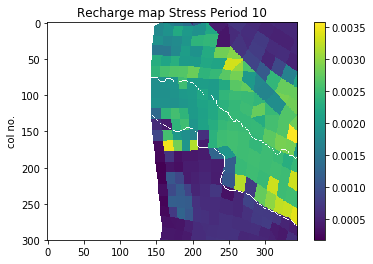

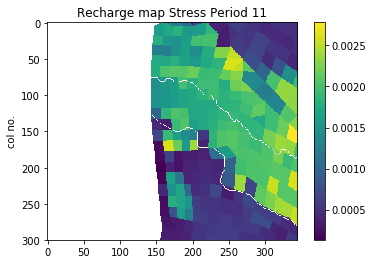

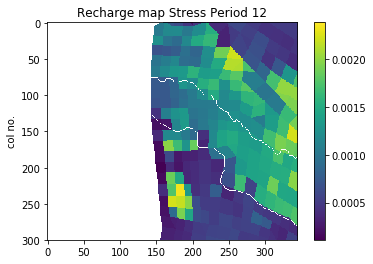

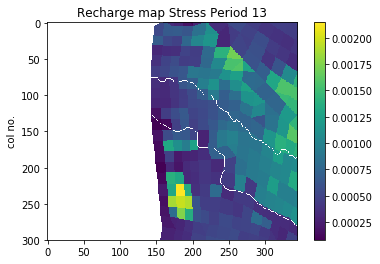

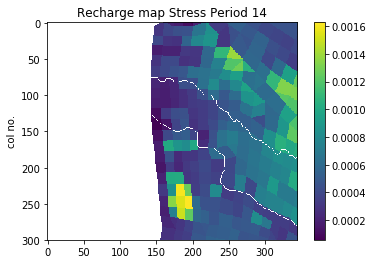

In [455]:
rech_arr = mload.rch.rech.array

#Filter out the river cells
tf = np.zeros((mload.nrow,mload.ncol),dtype=bool)
stds = 2.5
for kper in range(mload.nper):
    rech_arr_kper = rech_arr[kper,0,:,:]
    tf_kper = np.logical_or((rech_arr_kper>(np.mean(rech_arr_kper) + np.std(rech_arr_kper)*stds)), 
                            (rech_arr_kper<(np.mean(rech_arr_kper) - np.std(rech_arr_kper)*stds)))
    tf_kper = np.logical_or(tf_kper, (rech_arr_kper<=0))
    tf = np.logical_or(tf,tf_kper)
    
    
for kper in range(mload.nper):
    rech_arr_kper = rech_arr[kper,0,:,:]
    riv_mask = np.ma.masked_array(rech_arr_kper,tf)
    max_rch.append(riv_mask.max())
    min_rch.append(riv_mask.min())    
    
    #plot
    if not kper%1==0:
        continue
    if not kper in np.arange(0,15):
        continue
    plt.figure()
    plt.imshow(riv_mask)
    cb = plt.colorbar()
    #plt.clim(-0.005, 0.005)
    plt.ylabel('row no.')
    plt.ylabel('col no.')
    plt.title('Recharge map Stress Period {}'.format(kper))



Summer: (6.36e-06, 0.0008296) m
Winter: (0.001195, 0.02244) m


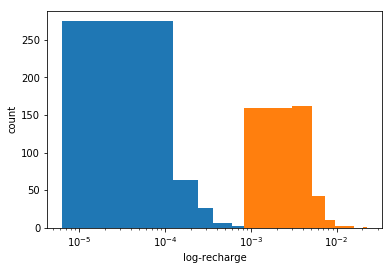

In [465]:
plt.hist(min_rch)
plt.hist(max_rch)
plt.xscale('log')
plt.xlabel('log-recharge')
plt.ylabel('count')

rng_summer = (min(min_rch),min(max_rch))
rng_winter = (max(min_rch),max(max_rch))
fname = 'rech_rng_precip'
save_obj(exp_dirname,(rng_summer,rng_winter),fname)
print('Summer:',rng_summer,'m')
print('Winter:',rng_winter,'m')

### Range of application rates during summer/dry season

#### Water Needs:
from : http://www.fao.org/docrep/s2022e/s2022e02.htm

see: SGD/WaterNeeds.xlsx

#### min of selected plants (m/day):
0.000127273	
#### max of selected plants (m/day): 
0.000271429
#### increase in application in order to flush out salts (p. comm, Curtis Hopkins):
N Marina area:
15-20%

SV area:
10-15%

In [471]:
rng_wel = (0.000127273*1.15,0.000271429*1.2)
fname = 'wel_rng_mday'
save_obj(exp_dirname,rng_wel,fname)
print('Well pumping:',rng_wel,'m/day')

rng_farm_rech =  (0.000127273*0.15,0.000271429*0.2)
fname = 'rech_rng_farm'
save_obj(exp_dirname,rng_farm_rech,fname)
print('Recharge due to ag application:',rng_farm_rech,'m/day')

Well pumping: (0.00014636395, 0.0003257148) m/day
Recharge due to ag application: (1.909095e-05, 5.42858e-05) m/day
